## Imports

In [600]:
import os
import random
import shap
import dice_ml
import joblib
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt

from catboost import CatBoostRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.base import BaseEstimator

shap.initjs()

## Constants

In [601]:
OUTPUT_DIR = "outputs/"
MODEL_DIR = os.path.join(OUTPUT_DIR, "models/")
DATA_SPLITS = os.path.join(OUTPUT_DIR, "splits/")

GLOBAL_SEED = 63

In [602]:
def set_global_seed():
    random.seed(GLOBAL_SEED)
    np.random.seed(GLOBAL_SEED)

set_global_seed()

## Load Data and Model

Using the best model found from previous section—Catboost

In [603]:
model_study = joblib.load(os.path.join(MODEL_DIR, "catboost_regressor.joblib"))

X_train = pd.read_csv(os.path.join(DATA_SPLITS,'X_train.csv'))
X_test = pd.read_csv(os.path.join(DATA_SPLITS, 'X_test.csv'))
y_train = pd.read_csv(os.path.join(DATA_SPLITS, 'y_train.csv'))
y_test = pd.read_csv(os.path.join(DATA_SPLITS, 'y_test.csv'))

In [604]:
best_params = model_study.best_params_
best_params = {k.removeprefix("estimator__"): v for k, v in best_params.items()}

best_model = CatBoostRegressor(**best_params, logging_level='Silent')
wrapped_model = MultiOutputRegressor(estimator=best_model)

In [605]:
wrapped_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x00000161400ECE50>)

## Feature Importance Explanation

Using SHAP

In [606]:
heating_explainer = shap.TreeExplainer(wrapped_model.estimators_[0])
heating_shap_values = heating_explainer(X_test)

cooling_explainer = shap.TreeExplainer(wrapped_model.estimators_[1])
cooling_shap_values = cooling_explainer(X_test)

### Plotting SHAP

1. Summary Plots (Global Importance)

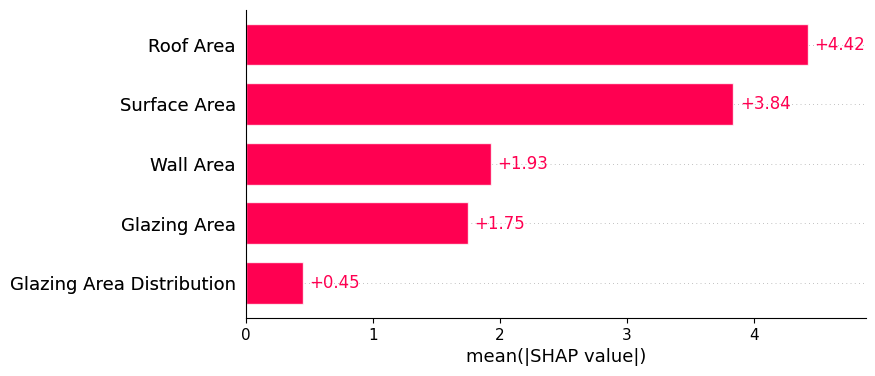

In [607]:
shap.plots.bar(heating_shap_values)

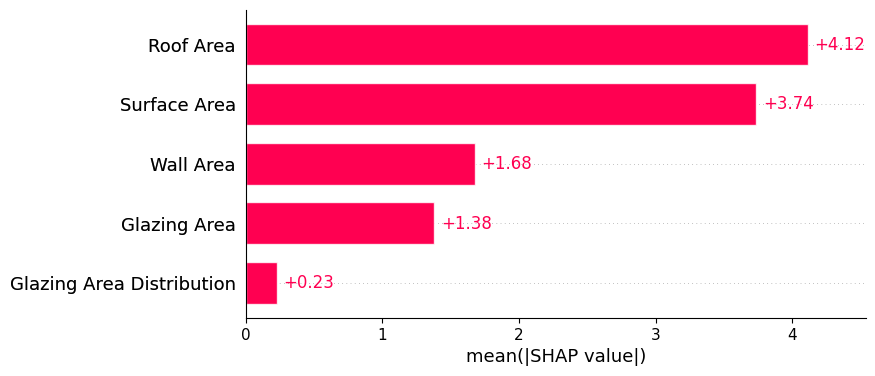

In [608]:
shap.plots.bar(cooling_shap_values)

2. Beeswarm plot (Global Importance)

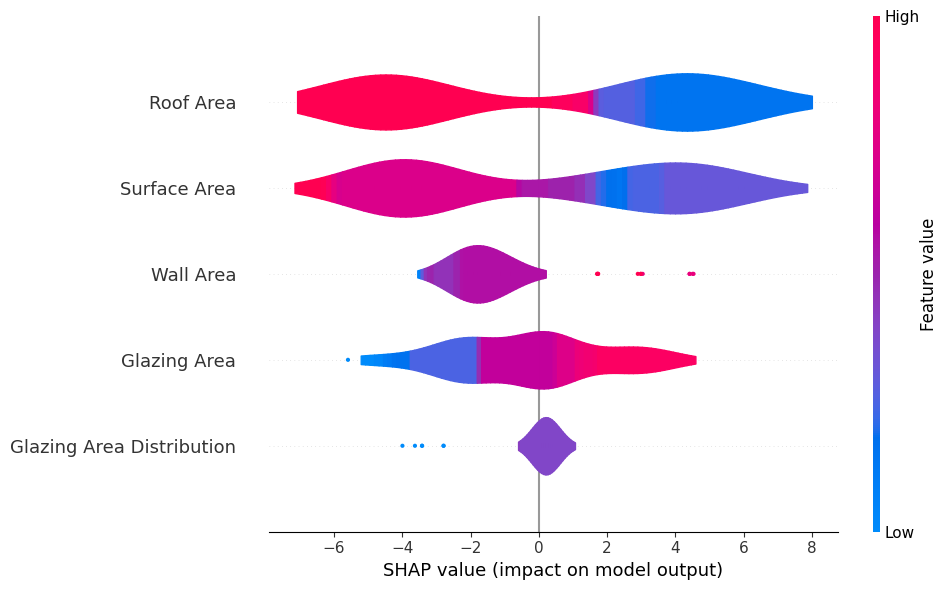

In [609]:
shap.plots.violin(heating_shap_values, show=False)
plt.gcf().set_size_inches(10, 6)
plt.tight_layout()
plt.show()

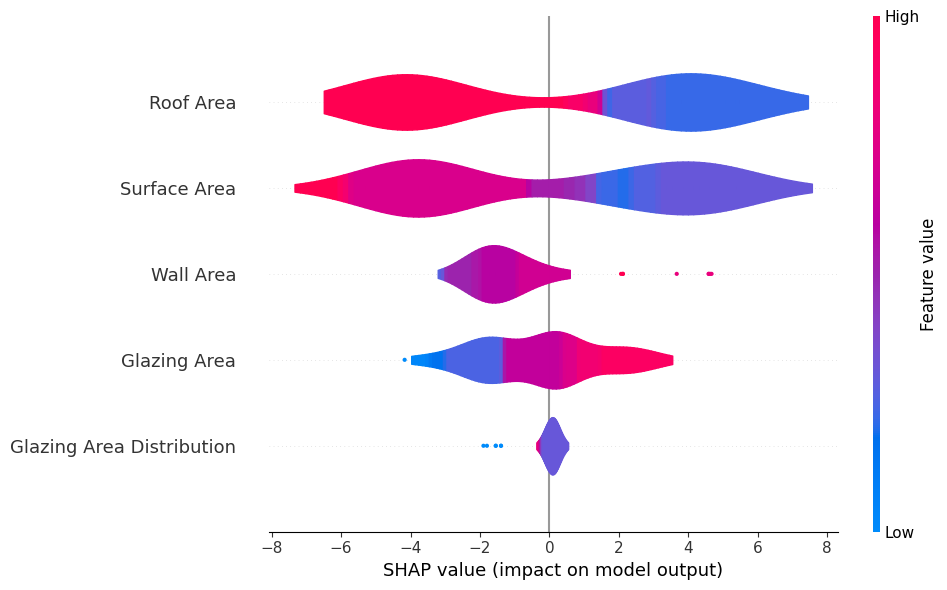

In [610]:
shap.plots.violin(cooling_shap_values, show=False)
plt.gcf().set_size_inches(10, 6)
plt.tight_layout()
plt.show()

3. Waterfall plot (Local Importance)

In [ ]:
rng = np.random.default_rng()
random_index = rng.integers(low=0, high=X_test.shape[0])

In [612]:
X_test.iloc[random_index]

Surface Area                 514.50
Wall Area                    294.00
Roof Area                    110.25
Glazing Area                   0.25
Glazing Area Distribution      5.00
Name: 13, dtype: float64

In [613]:
y_test.iloc[random_index]

Heating Load    28.58
Cooling Load    29.77
Name: 13, dtype: float64

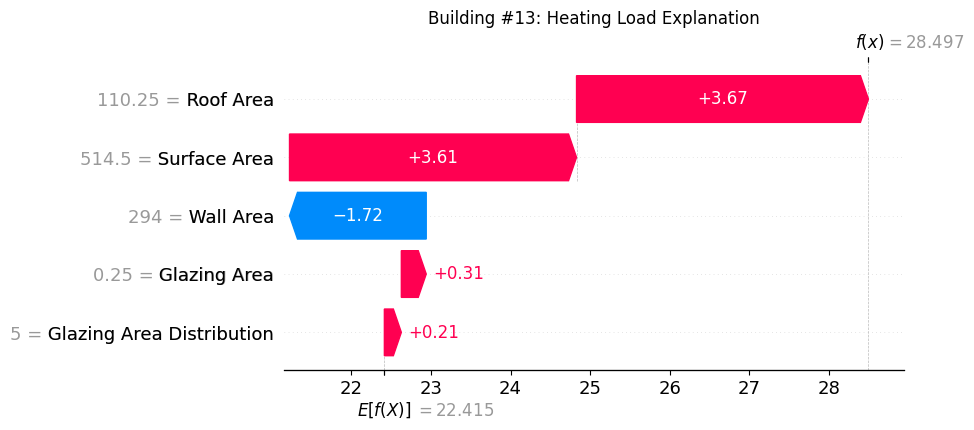

In [614]:
shap.waterfall_plot(
    shap.Explanation(
        values=heating_shap_values[random_index],
        base_values=heating_explainer.expected_value,
        data=X_test.iloc[random_index].values,
        feature_names=X_test.columns.to_list()
    ),
    show=False
)
plt.title(f"Building #{random_index}: Heating Load Explanation")
plt.show()

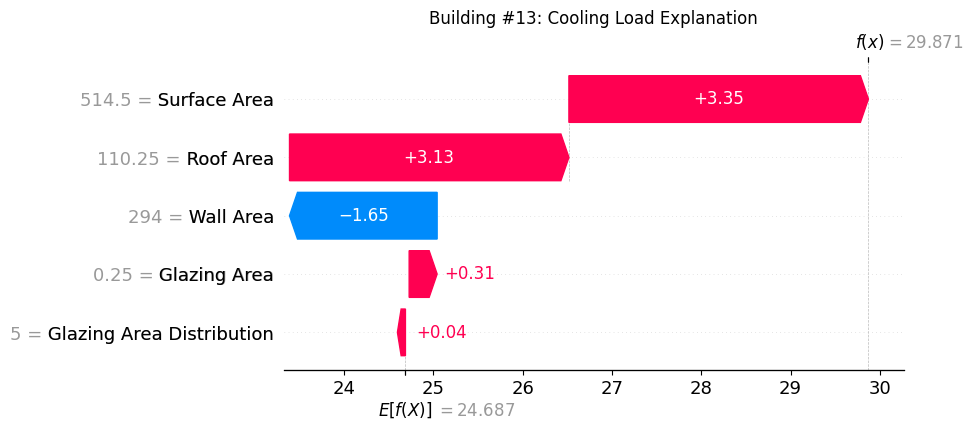

In [615]:
shap.waterfall_plot(
    shap.Explanation(
        values=cooling_shap_values[random_index],
        base_values=cooling_explainer.expected_value,
        data=X_test.iloc[random_index].values,
        feature_names=X_test.columns.to_list()
    ),
    show=False
)
plt.title(f"Building #{random_index}: Cooling Load Explanation")
plt.show()

## Counterfactual Explanation

Using DiCE for single aggregated target

In [616]:
y_train_combined = y_train.copy()
y_train_combined['Combined Load'] = y_train_combined['Heating Load'] + y_train_combined['Cooling Load']
y_train_combined.drop('Heating Load', axis=1, inplace=True)
y_train_combined.drop('Cooling Load', axis=1, inplace=True)

y_test_combined = y_test.copy()
y_test_combined['Combined Load'] = y_test_combined['Heating Load'] + y_test_combined['Cooling Load']
y_test_combined.drop('Heating Load', axis=1, inplace=True)
y_test_combined.drop('Cooling Load', axis=1, inplace=True)

y_train_combined.shape, y_test_combined.shape

((691, 1), (77, 1))

Train a model with the combined load

In [617]:
single_output_model = CatBoostRegressor(**best_params, logging_level='Silent')
single_output_model.fit(X_train, y_train_combined)

Create DiCE explainer

In [618]:
combined_df = pd.concat([X_train, y_train_combined], axis=1)
continuous_features = ['Surface Area', 'Wall Area', 'Roof Area', 'Glazing Area', 'Glazing Area Distribution']

In [ ]:
dice_data = dice_ml.Data(
    dataframe=combined_df,
    continuous_features=continuous_features,
    outcome_name='Combined Load'
)

dice_model = dice_ml.Model(model=single_output_model, backend='sklearn', model_type='regressor')
dice_explainer = dice_ml.Dice(data_interface=dice_data, model_interface=dice_model, method='random')

In [630]:
# Currently the total load of the previous building:
X_test.loc[random_index], y_test_combined.loc[random_index]

(Surface Area                 514.50
 Wall Area                    294.00
 Roof Area                    110.25
 Glazing Area                   0.25
 Glazing Area Distribution      5.00
 Name: 13, dtype: float64,
 Combined Load    58.35
 Name: 13, dtype: float64)

In [631]:
query_instance = X_test.loc[random_index].to_frame().T

counterfactual = dice_explainer.generate_counterfactuals(
    query_instances=query_instance,
    total_CFs=5,
    desired_range=[35, 45]
)

100%|██████████| 1/1 [00:00<00:00,  3.19it/s]


In [632]:
query_instance

,Surface Area,Wall Area,Roof Area,Glazing Area,Glazing Area Distribution
13,514.5,294.0,110.25,0.25,5.0


In [633]:
counterfactual.visualize_as_dataframe(show_only_changes=True)

Query instance (original outcome : 58.33479690551758)


,Surface Area,Wall Area,Roof Area,Glazing Area,Glazing Area Distribution,Combined Load
0,514.5,294.0,110.25,0.25,5.0,58.334797



Diverse Counterfactual set (new outcome: [35, 45])


,Surface Area,Wall Area,Roof Area,Glazing Area,Glazing Area Distribution,Combined Load
0,784.0,343.0,220.5,0.2,-,36.965992018042826
0,-,-,210.4,0.2,0.0,42.420466268017925
0,-,-,217.4,0.2,0.0,42.420466268017925
0,784.0,343.0,220.5,0.2,4.0,37.1293559739315
0,784.0,343.0,220.5,0.2,3.0,36.990762686763915


DiCE does not natively support multi-objective counterfactuals. Thus, we need to combine the loads in such a way that one load does not dominate the other-which can be done by normalizing, then use it on DiCE, generate counterfactuals, and finally, use the counterfactuals generated to get the actual values.

In [634]:
class MultiTargetWrapper(BaseEstimator):
    def __init__(self, model, heating_max, cooling_max):
        self.model = model
        self.y1_max = heating_max 
        self.y2_max = cooling_max

    def predict(self, X):
        preds = self.model.predict(X)
        y1 = preds[:, 0]
        y2 = preds[:, 1]
        
        y1_norm = y1 / self.y1_max
        y2_norm = y2 / self.y2_max
        
        composite_score = (y1_norm + y2_norm) / 2
        
        return composite_score

In [ ]:
heating_max = y_train.iloc[:, 0].max() 
cooling_max = y_train.iloc[:, 1].max()

multi_object_counterfactual_wrapper = MultiTargetWrapper(wrapped_model, heating_max, cooling_max)

multi_object_dice_data = dice_ml.Data(dataframe=X_train.assign(Composite_Score=0),
                 continuous_features=continuous_features,
                 outcome_name='Composite_Score')

multi_object_dice_model = dice_ml.Model(model=multi_object_counterfactual_wrapper, backend="sklearn", model_type='regressor')

multi_object_dice_explainer = dice_ml.Dice(multi_object_dice_data, multi_object_dice_model, method="random")

query_instance = X_test.iloc[random_index].to_frame().T
desired_range_in_percentage_of_max_value = [0.0, 0.5]

multi_target_counterfactuals = multi_object_dice_explainer.generate_counterfactuals(
    query_instance, 
    total_CFs=5, 
    desired_range=desired_range_in_percentage_of_max_value
)

multi_target_counterfactuals.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:01<00:00,  1.90s/it]

Query instance (original outcome : 0.6426355838775635)


,Surface Area,Wall Area,Roof Area,Glazing Area,Glazing Area Distribution,Composite_Score
0,514.5,294.0,110.25,0.25,5.0,0.642636



Diverse Counterfactual set (new outcome: [0.0, 0.5])


,Surface Area,Wall Area,Roof Area,Glazing Area,Glazing Area Distribution,Composite_Score
0,686.0,245.0,220.5,0.2,-,0.2967042138725825
0,-,245.0,199.4,0.2,0.0,0.4634479108383876
0,-,245.0,214.7,0.2,0.0,0.4634479108383876
0,-,271.3,220.5,0.2,0.0,0.4668857512760778


In [650]:
cf_df = multi_target_counterfactuals.cf_examples_list[0].final_cfs_df.drop('Composite_Score', axis=1)

# Predict using the model to see the actual split
real_predictions = wrapped_model.predict(cf_df)

# Check the maximum heating and cooling loads and the percentage limits that we want
print(f"Max heating load: {heating_max}")
print(f"Max cooling load: {cooling_max}")
print(f"Current heating load: {y_test.iloc[random_index]['Heating Load']}")
print(f"Current cooling load: {y_test.iloc[random_index]['Cooling Load']}")
print(f"Target max heating load: {heating_max * desired_range_in_percentage_of_max_value[1]}")
print(f"Target max cooling load: {cooling_max * desired_range_in_percentage_of_max_value[1]}")

Max heating load: 42.96
Max cooling load: 48.03
Current heating load: 28.58
Current cooling load: 29.77
Target max heating load: 21.48
Target max cooling load: 24.015


In [651]:
cf_df['Heating Load'] = real_predictions[:,0]
cf_df['Cooling Load'] = real_predictions[:,1]
cf_df

,Surface Area,Wall Area,Roof Area,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load
0,686.0,245.0,220.5,0.2,5.0,12.148019,14.919718
0,514.5,245.0,199.4,0.2,0.0,19.342960,22.893052
0,514.5,245.0,214.7,0.2,0.0,19.342960,22.893052
0,514.5,271.3,220.5,0.2,0.0,19.399445,23.160141
